In [8]:
#Import libraries and settings

#To perform array operations
import numpy as np

#Main plotting library
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

#Libaries for drawing figures and map projections
import cartopy
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

#Library for accessing files in the directory
import os

#To read in netCDF files
from netCDF4 import Dataset

#Library for using math functions
import math

#Library for collecting lists of files from folders
import glob

#Operator library with commands for joining data together
from operator import and_

import warnings
warnings.filterwarnings('ignore')

#Sets font size to 12
plt.rcParams.update({'font.size': 12})

#Option to keep numpy from printing in scientific notation by default
np.set_printoptions(suppress = True)

In [ ]:
#Work with a single file (MODIFY path, file name)

fname = 'D://Data/20200103/TROPOMI CO/' + 'S5P_OFFL_L2__CO_____20200103T033746_20200103T051916_11517_01_010302_20200104T172907.nc'

#Set the file name to read
file_id = Dataset(fname)

#Explore the contents of the file (UNCOMMENT the 'print' commands one by one to see various aspects of the file)

#Check the contents of the entire file
##print(file_id)

#Check the contents of the "groups" portion of the file
##print(file_id.groups)

#Check the contents of the "PRODUCT" portion of the file
##print(file_id.groups['PRODUCT'])

#Check the "qa_value" metadata
##print(file_id.groups['PRODUCT'].variables['qa_value'])

#Check the "carbonmonoxide_total_column" metadata
##print(file_id.groups['PRODUCT'].variables['carbonmonoxide_total_column'])

#Check the "carbonmonoxide_total_column" array values
##print(file_id.groups['PRODUCT'].variables['carbonmonoxide_total_column'][:,:])

In [33]:
print(type(file_id.groups['PRODUCT'].variables['carbonmonoxide_total_column'][:,:]))

<class 'numpy.ma.core.MaskedArray'>


In [3]:
#Check the units for the variables of interest (note: "1" means unitless)

print('Total column CO unit is', (file_id.groups['PRODUCT'].variables['carbonmonoxide_total_column'].__getattr__('units')))
print('Quality flag value is', (file_id.groups['PRODUCT'].variables['qa_value'].__getattr__('units')))
print('Latitude unit is', (file_id.groups['PRODUCT'].variables['latitude'].__getattr__('units')))
print('Longitude unit is', (file_id.groups['PRODUCT'].variables['longitude'].__getattr__('units')))

Total column CO unit is mol m-2
Quality flag value is 1
Latitude unit is degrees_north
Longitude unit is degrees_east


In [4]:
#Check the data type for the variables of interest

print('Total column CO data type is', (file_id.groups['PRODUCT'].variables['carbonmonoxide_total_column'][:,:].dtype))
print('Quality flag data type is', (file_id.groups['PRODUCT'].variables['qa_value'][:,:].dtype))
print('Latitude data type is', (file_id.groups['PRODUCT'].variables['latitude'][:].dtype))
print('Longitude data type is', (file_id.groups['PRODUCT'].variables['longitude'][:].dtype))

Total column CO data type is float32
Quality flag data type is float32
Latitude data type is float32
Longitude data type is float32


In [23]:
#Select and process CO data from a single file

#Read in CO data
CO_data = file_id.groups['PRODUCT'].variables['carbonmonoxide_total_column'][:,:]

#Select quality of CO data pixels using the "qa_value" variable (MODIFY)
#Science team recommends ignoring data with qa_value < 0.5
qa_value = file_id.groups['PRODUCT'].variables['qa_value'][:,:]
Quality_Mask = (qa_value < 0.5)
CO = np.ma.masked_where(Quality_Mask, CO_data)

#Read in latitude and longitude; convert longitude from [0,180] to [0,360] to avoid plotting errors near International Date Line
Lon_180 = file_id.groups['PRODUCT'].variables['longitude'][:,:]
Lon = (Lon_180 % 360)
Lat = file_id.groups['PRODUCT'].variables['latitude'][:,:]

In [24]:
#Review processed data (sanity check)

print('CO: minimum value is ' + str(np.min(CO)) + ';' + ' maximum value is ' + str(np.max(CO)))
print('Latitude: minimum value is ' + str(np.min(Lat)) + ' degrees;' + ' maximum value is ' + str(np.max(Lat)) + ' degrees')
print('Longitude: minimum value is ' + str(np.min(Lon)) + ' degrees;' + ' maximum value is ' + str(np.max(Lon)) + ' degrees')

CO: minimum value is 0.001646555; maximum value is 1.2838827
Latitude: minimum value is -89.963615 degrees; maximum value is 81.717445 degrees
Longitude: minimum value is 0.0016886574 degrees; maximum value is 359.9912 degrees


TypeError: Input z must be a 2D array.

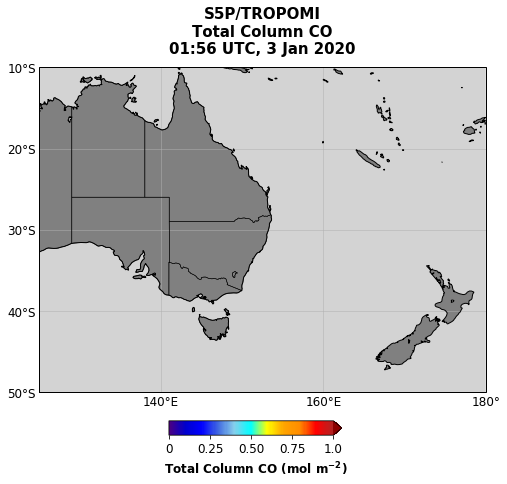

In [26]:
#Plot CO from a single data file

#Set up figure and map projection: PlateCarree(central_longitude) (MODIFY central_longitude)
#Plate Carree: equidistant cylindrical projection w/equator as the standard parallel; default central_longitude = 0
#Use central_longitude = 180 to avoid plotting errors near International Date Line
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(central_longitude = 180))

#Set up and label the lat/lon grid
lon_formatter = LongitudeFormatter(zero_direction_label = True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360], crs = ccrs.PlateCarree())
ax.set_yticks([-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80], crs = ccrs.PlateCarree())

#Set lat/lon ticks and gridlines
ax.tick_params(length = 0)
ax.grid(linewidth = 0.5, zorder = 3)

#Set domain for map [xmin, xmax, ymin, ymax] (MODIFY)
#Use 360 degrees for longitude coordinates (i.e, -100 = 260)
ax.set_extent([125, 180, -10, -50], crs = ccrs.PlateCarree())

#Draw coastlines/borders using Cartopy; zorder sets drawing order for layers
ax.coastlines(resolution = '50m', zorder = 3)
ax.add_feature(cfeature.BORDERS, zorder = 3)
ax.add_feature(cfeature.NaturalEarthFeature(category = 'cultural', name = 'admin_1_states_provinces', scale = '50m'), facecolor = 'none', lw = 0.5, edgecolor = 'black', zorder = 2)
ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'ocean', scale = '50m'), facecolor = 'lightgrey')
ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'land', scale = '50m'), facecolor = 'grey')
ax.add_feature(cfeature.NaturalEarthFeature(category = 'physical', name = 'lakes', scale = '50m'), facecolor = 'lightgrey', edgecolor = 'black', zorder = 2)

#Add and format title (MODIFY name)
plt.title('S5P/TROPOMI\nTotal Column CO\n01:56 UTC, 3 Jan 2020', y = 1.025, ma = 'center', size = 15, weight = 'bold')

#Create custom color map for plot and colorbar
#.set_over sets color for plotting data > max
color_map = mpl.colors.LinearSegmentedColormap.from_list('custom_AOD', [(0, 'indigo'),(0.1, 'mediumblue'), (0.2, 'blue'), (0.3, 'royalblue'), (0.4, 'skyblue'), (0.5, 'cyan'), (0.6, 'yellow'), (0.7, 'orange'), (0.8, 'darkorange'), (0.9, 'red'), (1, 'firebrick')], N = 150)
color_map.set_over('darkred')

#Add and format continuous colorbar
##cbar_ax are dummy variables; location/attributes of colorbar set by .set_position (x0, y0, width, height) to scale automatically with plot
cbar_ax = fig.add_axes([0, 0, 0, 0])
plt.draw()
posn = ax.get_position()
cbar_ax.set_position([0.35, posn.y0 - 0.06, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin = 0, vmax = 1)
cb = mpl.colorbar.ColorbarBase(cbar_ax, cmap = color_map, norm = norm, orientation = 'horizontal', ticks = [0, 0.25, 0.5, 0.75, 1], extend = 'max')
cb.set_label(label = 'Total Column CO (mol m$\mathregular{^{-2}}$)', size = 'medium', weight = 'bold')
cb.ax.set_xticklabels(['0', '0.25', '0.50', '0.75', '1.0'])
cb.ax.tick_params(labelsize = 'medium')

#Set range for plotting data (data min, data max, contour interval) (MODIFY contour interval)
#interval: 0.1 = runs faster/coarser resolution, 0.01 = runs slower/higher resolution
data_range = np.arange(0, 1.1, 0.1)

#Create filled contour plot of AOD data
Plot = ax.contourf(Lon, Lat, CO, data_range, cmap = color_map, extend = 'max', zorder = 3, transform = ccrs.PlateCarree())

#Show figure
plt.show()

#Save figure as a .png file (MODIFY path, name)
fig.savefig('D://Data/20200103/TROPOMI CO/Figures/S5P_TROPOMI_CO_20200103_0156', bbox_inches = 'tight', dpi = 150)